In [1]:
# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

plt.ion() #주피터에서 그래프 프린트하게 해주는 변수

In [3]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = 'data/'  # 데이터 파일
args.train_csv = args.default_path+'hotel_bookings.csv'

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []
# with open(args.save_results, 'r') as file:
#     args.results = json.load(file)

args.results

[]

# 1단계: 데이터 로드 및 기본 정보 확인
print("=== 호텔 예약 데이터 로드 ===")

# 데이터 로드
try:
    df = pd.read_csv(args.train_csv)

    # 타겟 변수 확인
    if 'is_canceled' in df.columns:
        print(f"\n=== 타겟 변수 분포 ===")
        target_dist = df['is_canceled'].value_counts()
        print(f"예약 유지: {target_dist[0]:,}건 ({target_dist[0]/len(df)*100:.1f}%)")
        print(f"예약 취소: {target_dist[1]:,}건 ({target_dist[1]/len(df)*100:.1f}%)")
    


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(args.train_csv)

# 2.기본 DEA
- 전체 데이터 특성 파악

In [8]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [27]:
# 결측치가 있는 컬럼과 그 결측치의 비율
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
missing_percent = (missing_summary / len(df))
missing_summary, missing_percent

(children         4
 country        488
 agent        16340
 company     112593
 dtype: int64,
 children    0.000034
 country     0.004087
 agent       0.136862
 company     0.943069
 dtype: float64)

Text(0.5, 1.0, '수치형 변수 상관관계 히트맵')

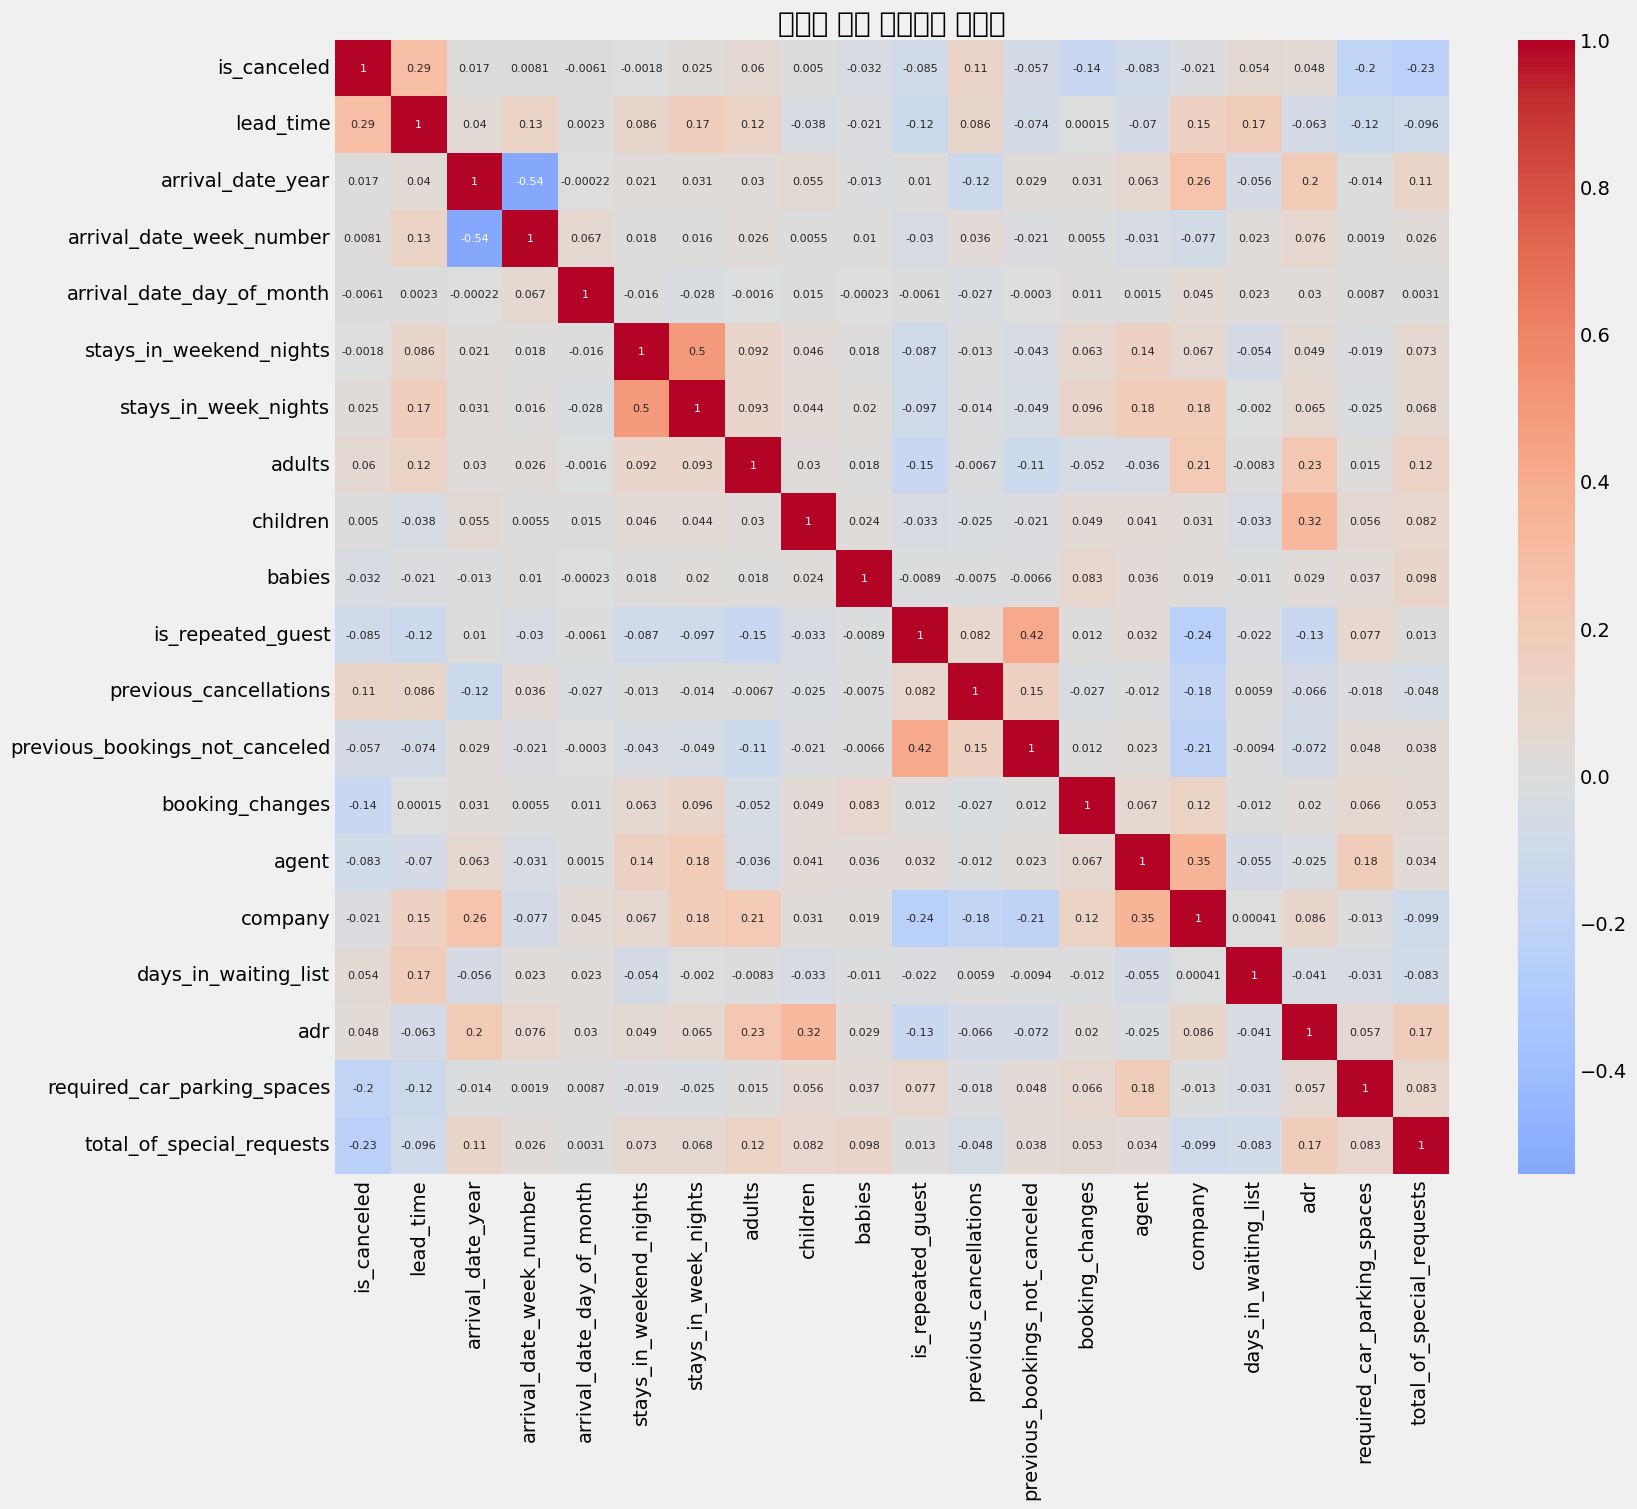

In [34]:
# 수치형 변수만 선택해서 상관계수
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(16, 14))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, annot_kws={'size': 8})
plt.title('수치형 변수 상관관계 히트맵')

In [38]:
# 상관계수 매트릭스
corr_matrix = df[numeric_cols].corr()

# stack으로 펼치기
corr_pairs = corr_matrix.stack()

# 자기 자신과의 상관계수(1.0) 제거 및 중복 제거
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)]

# 0.02 이상인 것만 필터링
high_corr_pairs = corr_pairs[abs(corr_pairs) >= 0.02]

# DataFrame으로 변환하고 절댓값 컬럼 추가
high_corr_df = high_corr_pairs.reset_index()
high_corr_df.columns = ['Variable_1', 'Variable_2', 'Correlation']
high_corr_df['Abs_Correlation'] = abs(high_corr_df['Correlation'])

# 절댓값 기준으로 내림차순 정렬
high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)

print("상관계수 0.02 이상인 변수 쌍 (절댓값 큰 순서):")
print(high_corr_df)

상관계수 0.02 이상인 변수 쌍 (절댓값 큰 순서):
                   Variable_1                      Variable_2  Correlation  \
24   arrival_date_week_number               arrival_date_year    -0.540561   
37       stays_in_week_nights         stays_in_weekend_nights     0.498969   
73          is_repeated_guest  previous_bookings_not_canceled     0.418056   
100                     agent                         company     0.350746   
126                       adr                        children     0.324854   
..                        ...                             ...          ...   
57                   children  previous_bookings_not_canceled    -0.021072   
63                     babies                       lead_time    -0.020915   
27   arrival_date_week_number  previous_bookings_not_canceled    -0.020904   
104                   company                     is_canceled    -0.020642   
64                     babies            stays_in_week_nights     0.020191   

     Abs_Correlation  
24       

Text(0.5, 1.0, '상관계수 0.02 이상만 표시한 히트맵')

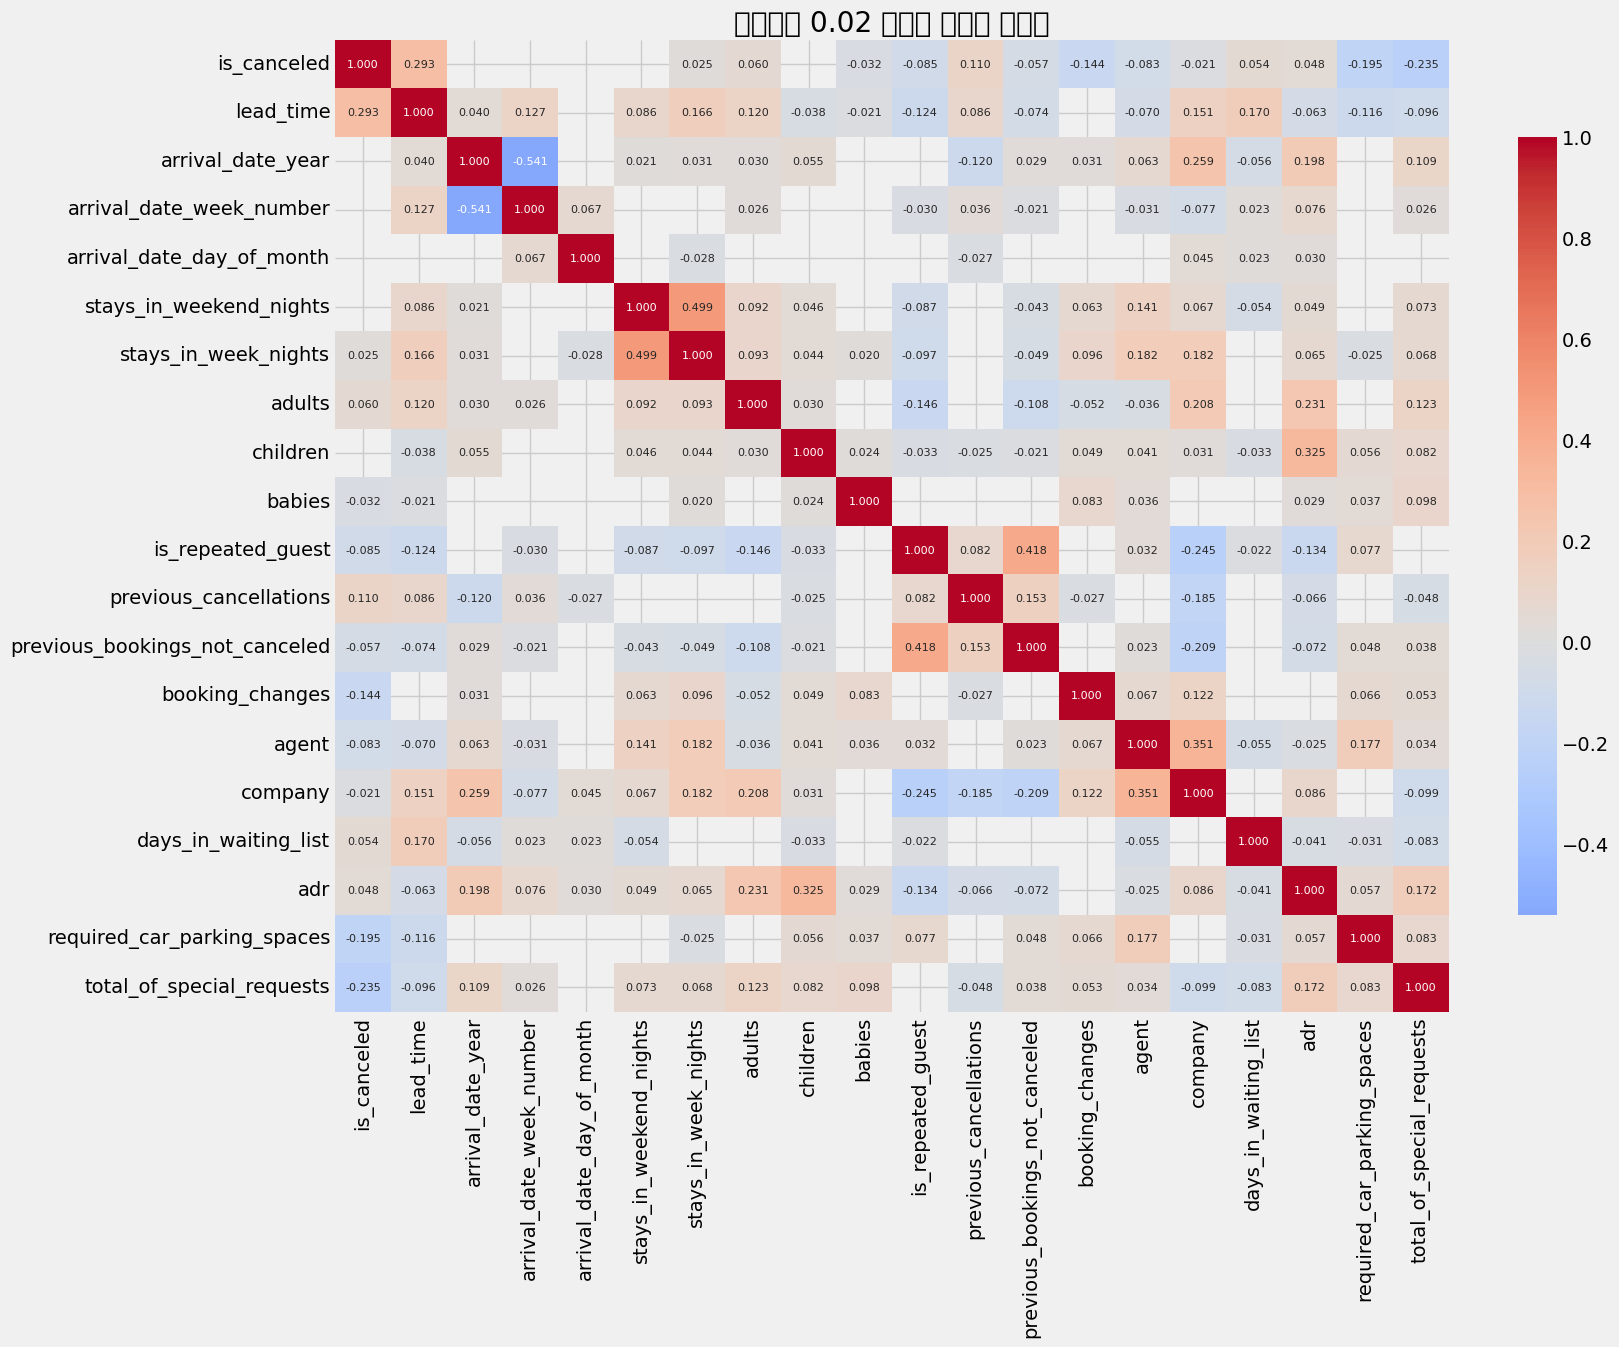

In [ ]:
# 0.02 이상인 것만 표시하는 마스크
corr_matrix = df[numeric_cols].corr()
mask = abs(corr_matrix) < 0.02

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            mask=mask,  # 0.02 미만은 회색으로
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            annot_kws={'size': 8},
            cbar_kws={'shrink': .8})
plt.title('상관계수 0.02 이상만 표시한 히트맵')

In [ ]:
# data폴더에 저장 (폴더가 없으면 생성)
import os
os.makedirs('results', exist_ok=True)

high_corr_df.to_csv('data/high_correlation_pairs.csv', 
                    index=False,
                    encoding='utf-8-sig')
print("CSV 파일이 저장되었습니다: data/high_correlation_pairs.csv")

CSV 파일이 저장되었습니다: data/high_correlation_pairs.csv


: 

# 3.데이터 분할 
→ Train/Validation/Test

# 4.Train 데이터로만 상세 분석:
- 결측치 처리 방법 결정
- 피처 엔지니어링
- 스케일링 파라미터 학습

# 5.모델 학습 → Train 데이터

# 6.하이퍼파라미터 튜닝 → Validation 데이터로 검증
- Cv - train데이터 내에서만 사용

# 7.최종 평가 → Test 데이터 (한 번만!)

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape  # 테스트에는 타겟이 없어서 컬럼이 하나 작음